In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
import datetime
%matplotlib inline

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

## 线性回归

### 准备数据

In [3]:
n = 400 # 样本数量
X = 10 * torch.rand((n, 2)) - 5.0 # (n, 2)
w0 = torch.tensor([[2.0], [-3.0]]) # (2, 1)
b0 = torch.tensor([[10.0]]) # (1, 1)
Y = torch.mm(X, w0) + b0 + torch.normal(0.0, 2.0, size=(n, 1)) # Y (n, 1)

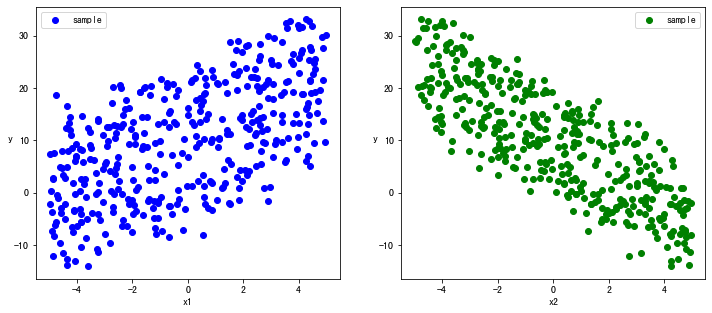

In [4]:
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0].numpy(), Y[:, 0].numpy(), c='b', label='sample')
ax1.legend()
plt.xlabel('x1')
plt.ylabel('y', rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1].numpy(), Y[:, 0].numpy(), c='g', label='sample')
ax2.legend()
plt.xlabel('x2')
plt.ylabel('y', rotation=0)
plt.show()

In [5]:
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        # index_select 第一个参数 选取的维度 0: 行, 1: 列
        yield features.index_select(0, indexs), labels.index_select(0, indexs)

batch_size = 8
features, labels = next(data_iter(X, Y, batch_size))
print(features)
print(labels)

tensor([[-2.6948,  2.2475],
        [ 2.4933, -3.1589],
        [-3.7449,  0.4064],
        [ 2.6525,  3.6387],
        [ 2.5608, -0.9160],
        [ 2.1194,  1.7910],
        [ 4.7811, -0.3087],
        [-2.3327, -3.9844]])
tensor([[-2.7290],
        [21.8872],
        [ 1.7197],
        [ 5.5106],
        [19.4348],
        [ 8.8936],
        [19.5488],
        [13.0225]])


### 定义模型

In [6]:
class LinearRegression:
    def __init__(self):
        self.w = torch.randn_like(w0, requires_grad=True)
        self.b = torch.zeros_like(b0, requires_grad=True)
    
    def forward(self, x):
        return x @ self.w + self.b
    
    def loss_func(self, y_pred, y_true):
        return torch.mean((y_pred - y_true) ** 2 / 2)
    
model = LinearRegression()

### 训练模型

In [7]:
def train_step(model, features, labels):
    predictions = model.forward(features)
    loss = model.loss_func(predictions, labels)
    
    # 反向传播
    loss.backward()
    
    with torch.no_grad():
        model.w -= 0.001 * model.w.grad
        model.b -= 0.001 * model.b.grad
        
        model.w.grad.zero_()
        model.b.grad.zero_()
    return loss

In [8]:
batch_size = 10
features, labels = next(data_iter(X, Y, batch_size))
train_step(model, features, labels)

tensor(34.4830, grad_fn=<MeanBackward0>)

In [9]:
def train_model(model, epochs):
    for epoch in range(1, epochs + 1):
        for features, labels in data_iter(X, Y, 10):
            loss = train_step(model, features, labels)
        if epoch % 200 == 0:
            printbar()
            print('epoch = {}, loss = {}'.format(epoch, loss.item()))
            print('model.w = {}'.format(model.w.data))
            print('model.b = {}'.format(model.b.data))
            
train_model(model, epochs=1000)


================================================================================2021-06-18 09:33:34
epoch = 200, loss = 1.8075441122055054
model.w = tensor([[ 2.0085],
        [-2.9808]])
model.b = tensor([[9.9492]])

================================================================================2021-06-18 09:33:36
epoch = 400, loss = 2.3188576698303223
model.w = tensor([[ 2.0105],
        [-2.9805]])
model.b = tensor([[9.9527]])

================================================================================2021-06-18 09:33:37
epoch = 600, loss = 1.0932457447052002
model.w = tensor([[ 2.0087],
        [-2.9803]])
model.b = tensor([[9.9527]])

================================================================================2021-06-18 09:33:39
epoch = 800, loss = 1.0265281200408936
model.w = tensor([[ 2.0078],
        [-2.9789]])
model.b = tensor([[9.9526]])

================================================================================2021-06-18 09:33:40
epoch = 1000, loss = 1.4856

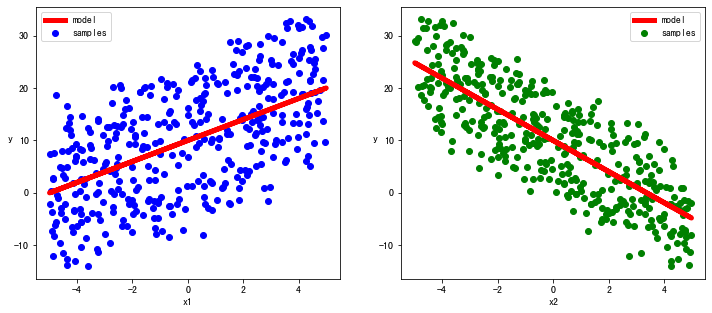

In [10]:
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0].numpy(), Y[:, 0].numpy(), c='b', label='samples')
ax1.plot(X[:, 0].numpy(), (model.w[0].data * X[:, 0] + model.b[0].data).numpy(),
         '-r',
         linewidth=5.0,
         label='model')
ax1.legend()
plt.xlabel('x1')
plt.ylabel('y', rotation=0)


ax2 = plt.subplot(122)
ax2.scatter(X[:, 1].numpy(), Y[:, 0].numpy(), c='g', label='samples')
ax2.plot(X[:, 1].numpy(), (model.w[1].data*X[:, 1] + model.b[0].data).numpy(),
         '-r',
         linewidth=5.0,
         label='model')
ax2.legend()
plt.xlabel('x2')
plt.ylabel('y', rotation=0)

plt.show()

## DNN二分类模型